In [1]:
from preamble import *
% matplotlib notebook

# Gaussian Processes
# Check out http://scikit-learn.org/dev/modules/gaussian_process.html

### download data from https://s3.amazonaws.com/tripdata/201307-201402-citibike-tripdata.zip

In [29]:
from glob import glob
dfs = []
for file in glob("data/citibike/*.csv"):
    dfs.append(pd.read_csv(file))

In [30]:
data = pd.concat(dfs)

In [31]:
data.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

In [32]:
data.head()


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,326,2013-10-01 00:01:08,2013-10-01 00:06:34,239,Willoughby St & Fleet St,40.691966,-73.981302,366,Clinton Ave & Myrtle Ave,40.693261,-73.968896,16052,Subscriber,1982,1
1,729,2013-10-01 00:01:21,2013-10-01 00:13:30,322,Clinton St & Tillary St,40.696192,-73.991218,398,Atlantic Ave & Furman St,40.691652,-73.999979,19412,Customer,\N,0
2,520,2013-10-01 00:01:24,2013-10-01 00:10:04,174,E 25 St & 1 Ave,40.738177,-73.977387,403,E 2 St & 2 Ave,40.725029,-73.990697,19645,Subscriber,1984,1
3,281,2013-10-01 00:01:25,2013-10-01 00:06:06,430,York St & Jay St,40.701485,-73.986569,323,Lawrence St & Willoughby St,40.692362,-73.986317,16992,Subscriber,1985,1
4,196,2013-10-01 00:01:27,2013-10-01 00:04:43,403,E 2 St & 2 Ave,40.725029,-73.990697,401,Allen St & Rivington St,40.720196,-73.989978,15690,Subscriber,1986,1


In [33]:
data['one'] = 1
data['starttime'] = pd.to_datetime(data.starttime)
data = data.set_index("starttime")

In [123]:
data_resampled = data.groupby("start station id").one.resample("3h").sum()

In [124]:
per_station = data_resampled.unstack(level=0).fillna(0)

<IPython.core.display.Javascript object>


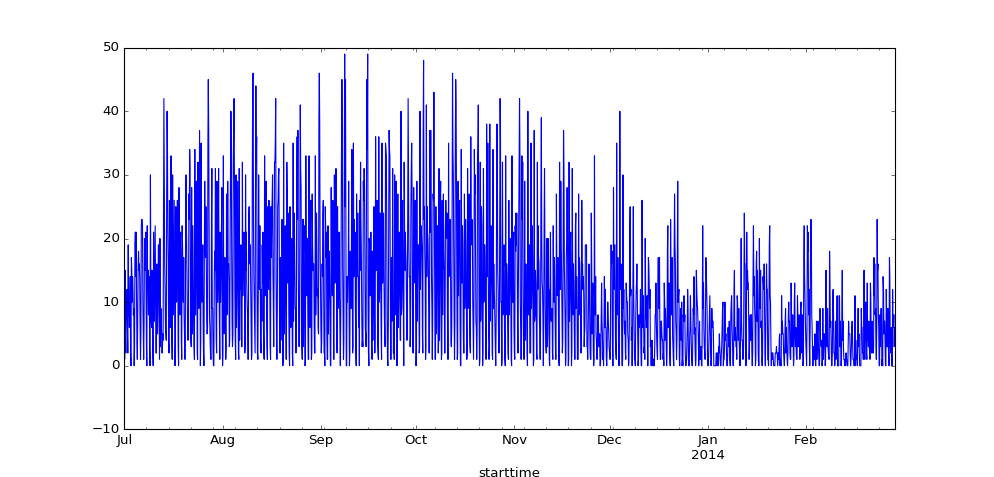

In [133]:
plt.figure()
per_station[301].plot()

In [134]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [140]:
y = per_station[301].values
X = np.arange(len(y)).reshape(-1, 1)

In [141]:
gp = GaussianProcessRegressor().fit(X, y)

<IPython.core.display.Javascript object>


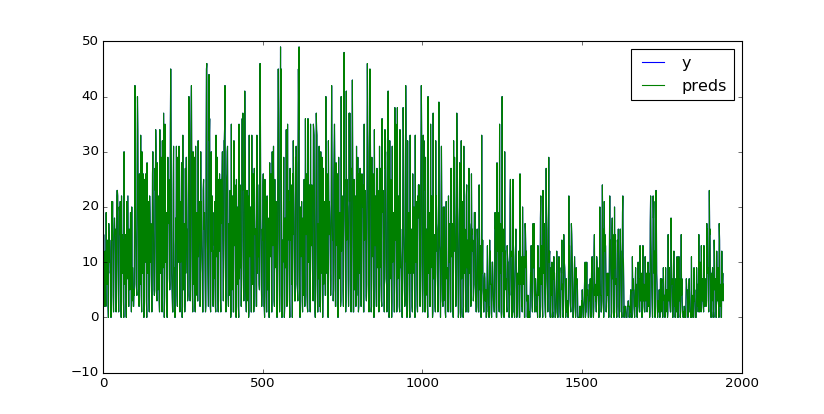

In [146]:
plt.figure()
plt.plot(y, label="y")
plt.plot(gp.predict(X), label="preds")
plt.legend()

In [147]:
gp.kernel_

1**2 * RBF(length_scale=1)

In [216]:
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel
gp = GaussianProcessRegressor(alpha=1, normalize_y=True, kernel = 1.0 * RBF(length_scale_bounds=(2, 500)) + 1.0 * RBF(length_scale_bounds=(50, 1000))
                              + 1.0 * RBF(length_scale=100, length_scale_bounds=(2, 500)) * ExpSineSquared(periodicity=8, periodicity_bounds="fixed")  # + 1.0 * WhiteKernel(noise_level=1)
                              + 1.0 * RBF(length_scale=100, length_scale_bounds=(2, 500)) * ExpSineSquared(periodicity=56, periodicity_bounds="fixed")).fit(X[1500], y[1500])

<IPython.core.display.Javascript object>


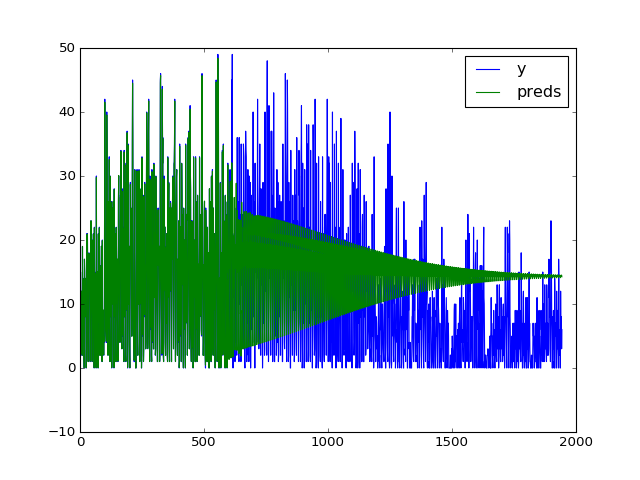

In [217]:
plt.figure()
plt.plot(y, label="y")
plt.plot(gp.predict(X), label="preds")
plt.legend()

In [218]:
gp.kernel_

2.06**2 * RBF(length_scale=2) + 1.62**2 * RBF(length_scale=178) + 6.25**2 * RBF(length_scale=500) * ExpSineSquared(length_scale=0.00122, periodicity=8) + 7.37**2 * RBF(length_scale=38.7) * ExpSineSquared(length_scale=0.016, periodicity=56)

# Exercise
Pick a subset of stations from a particular area of the city. Can you use location information to improve the estimates? Can you make predictions for a station given on other stations?